In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/graphene-kirigami/graphene_processed.nc


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__, torchvision.__version__

('1.2.0', '0.4.0a0+6b959ee')

# Read input data

In [3]:
ds = xr.open_dataset('/kaggle/input/graphene-kirigami/graphene_processed.nc')
ds

<xarray.Dataset>
Dimensions:       (sample: 29791, x: 80, x_c: 5, y: 30, y_c: 3)
Dimensions without coordinates: sample, x, x_c, y, y_c
Data variables:
    coarse_image  (sample, y_c, x_c) float32 ...
    fine_image    (sample, y, x) float32 ...
    strain        (sample) float32 ...
    stress        (sample) float32 ...

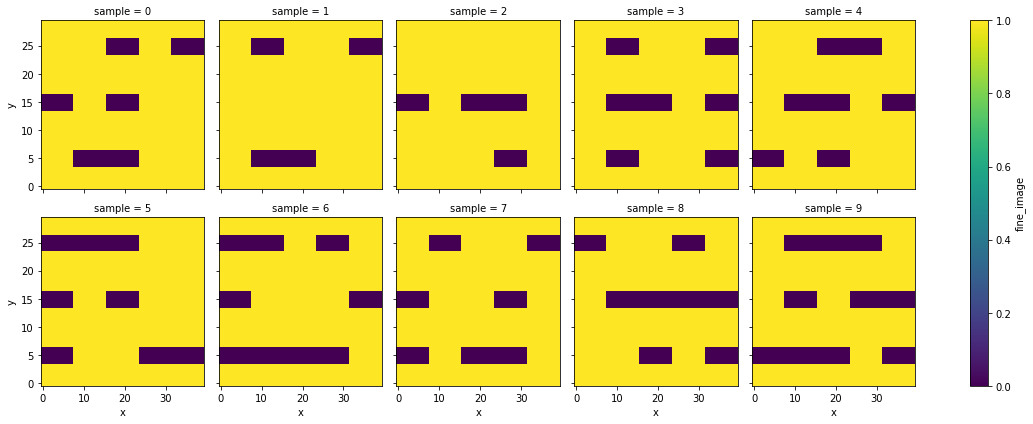

In [4]:
ds['fine_image'].isel(sample=slice(0, 10), x=slice(None, None, 2)).plot(col='sample', col_wrap=5)

# Conver to torch dataset

In [5]:
# X = ds['coarse_image'].values  # the coarse 3x5 image seems enough
X = ds['fine_image'].values  # the same model works worse on higher resolution image

y = ds['strain'].values

X = X[..., np.newaxis]  # add channel dimension
y = y[:, np.newaxis]  # pytorch wants ending 1 dimension

# pytorch conv2d wants channel-first, unlike Keras
X = X.transpose([0, 3, 1, 2])  # (sample, x, y, channel) -> (sample, channel, x, y)

X.shape, y.shape

((29791, 1, 30, 80), (29791, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((23832, 1, 30, 80), (5959, 1, 30, 80))

In [7]:
# https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

trainset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train), torch.from_numpy(y_train)
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2
)

In [8]:
dataiter = iter(trainloader)
inputs, labels = dataiter.next()
inputs.shape, labels.shape  # batch, channel, x, y

(torch.Size([32, 1, 30, 80]), torch.Size([32, 1]))

# Train PyTorch model

In [9]:
#  https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
      
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, in_channels=3):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
      

def ResNet18(**kwargs):
    return ResNet(BasicBlock, [2,2,2,2], **kwargs)

def ResNet34(**kwargs):
    return ResNet(BasicBlock, [3,4,6,3], **kwargs)
  
net = ResNet18(in_channels=1, num_classes=1)

In [10]:
# Check GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
%time net.to(device)
;

CPU times: user 2.61 s, sys: 884 ms, total: 3.49 s
Wall time: 3.52 s


''

In [12]:
# net(inputs.to(device))  # fails
net(inputs[:,:,:,::2].to(device));  # works

In [13]:
%%time

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        # Our ResNet forward path crashes when the image aspect ratio is too large
        # Subsample 30x80 image to 30x40 to prevent it from crashing
        inputs, labels = data[0][:,:,:,::2].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.1141
[1,   400] loss: 0.0154
[1,   600] loss: 0.0085
[2,   200] loss: 0.0067
[2,   400] loss: 0.0056
[2,   600] loss: 0.0061
[3,   200] loss: 0.0066
[3,   400] loss: 0.0079
[3,   600] loss: 0.0067
[4,   200] loss: 0.0052
[4,   400] loss: 0.0058
[4,   600] loss: 0.0050
[5,   200] loss: 0.0048
[5,   400] loss: 0.0052
[5,   600] loss: 0.0057
[6,   200] loss: 0.0047
[6,   400] loss: 0.0050
[6,   600] loss: 0.0042
[7,   200] loss: 0.0047
[7,   400] loss: 0.0048
[7,   600] loss: 0.0036
[8,   200] loss: 0.0041
[8,   400] loss: 0.0048
[8,   600] loss: 0.0038
[9,   200] loss: 0.0046
[9,   400] loss: 0.0040
[9,   600] loss: 0.0041
[10,   200] loss: 0.0033
[10,   400] loss: 0.0039
[10,   600] loss: 0.0036
Finished Training
CPU times: user 2min 58s, sys: 41.7 s, total: 3min 40s
Wall time: 3min 46s


# Evaluate

In [14]:
testset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test), torch.from_numpy(y_test)
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2
)

# do shuffle input at evaluation, so the output matches the original numpy label
trainloader_noshuffle = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=False, num_workers=2
)

In [15]:
# predict batch-by-batch to prevent GPU out-of-memory error

def predict(net, loader):
    y_pred_list = []
    with torch.no_grad():
        
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]

            inputs, labels = data[0][:,:,:,::2].to(device), data[1].to(device)

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            if i % 200 == 199:
                print('[%5d] loss: %.4f' % (i + 1, running_loss / 200))
                running_loss = 0.0
            
            y_pred_list.append(outputs.cpu().numpy())
        
    y_pred = np.concatenate(y_pred_list)
    
    return y_pred

%time y_train_pred = predict(net, trainloader_noshuffle)
%time y_test_pred = predict(net, testloader)

y_train_pred.shape, y_test_pred.shape

[  200] loss: 0.0043
[  400] loss: 0.0047
[  600] loss: 0.0043
CPU times: user 6.24 s, sys: 2.18 s, total: 8.42 s
Wall time: 8.85 s
CPU times: user 1.51 s, sys: 640 ms, total: 2.15 s
Wall time: 2.29 s


((23832, 1), (5959, 1))

In [16]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.8624682481366411, 0.87003144304673)

In [17]:
mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)

(0.004457539, 0.0042633065)

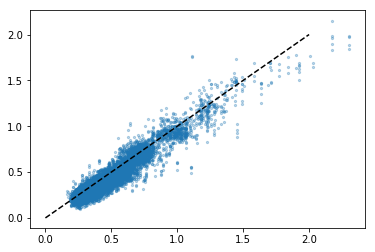

In [18]:
plt.scatter(y_train, y_train_pred, alpha=0.3, s=5)
plt.plot([0, 2], [0, 2], '--', c='k')

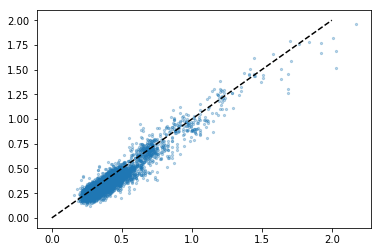

In [19]:
plt.scatter(y_test, y_test_pred, alpha=0.3, s=5)
plt.plot([0, 2], [0, 2], '--', c='k')